In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
customPalette = sns.set_palette(sns.color_palette(colors))

In [3]:
# importing data
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)
# data processing
train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass','MoSold'],
                                             remove_PID = False
                                        )

# feature engineering wrapper
train, test = helper.feature_engineering_wrapper(train, test)

# importing school feature
schools = pd.read_csv('schoolFeatures.csv',index_col = 0)
school_keep = [
    'PID',
    'closestSchool'
]
schools = schools[school_keep]

# merge school feature onto original data set.
train = train.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')
test = test.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')

train = train.dropna(subset=['closestSchool'])
train = train.reset_index(drop=True)

test = test.dropna(subset=['closestSchool'])
test = test.reset_index(drop=True)

In [4]:
train_raw = train.copy()
test_raw = test.copy()

X_train = train_raw.drop(['SalePrice','PID'],axis='columns')
y_train = np.log(train_raw['SalePrice'])
X_test = test_raw.drop(['SalePrice','PID'],axis='columns')
y_test = np.log(test_raw['SalePrice'])

In [5]:
categorical = train.select_dtypes(['object','bool']).columns.to_list()

# XGBoost using OrdinalEncoder

In [6]:
transformer = ColumnTransformer([("Cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), categorical)], 
                                remainder='passthrough')

X_train_ = transformer.fit_transform(X_train)

boost = xgb.XGBRegressor(eta=0.1, max_depth=10, n_estimators=100, subsample=0.58)
boost.fit(X_train_, y_train)

X_test_ = transformer.transform(X_test)

print(boost.score(X_train_, y_train))
print(boost.score(X_test_, y_test))

0.997045157372353
0.9221097915044227


### XGBoost being tuned by subsample size.

In [7]:
transformer = ColumnTransformer([("Cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), categorical)], 
                                remainder='passthrough')

X = transformer.fit_transform(X_train)
y = y_train

boost = xgb.XGBRegressor(eta=0.1, max_depth=10, n_estimators=100)
param_grid = {'subsample' : [0.2, 0.4, 0.6, 0.8, 1]}
grid = GridSearchCV(boost, param_grid, scoring='r2', n_jobs=-1)
grid.fit(X,y)

cv_df = pd.DataFrame({'subsample':grid.cv_results_['param_subsample'].data,
                     'mean_test_score':grid.cv_results_['mean_test_score'],
                      'split0_test_score':grid.cv_results_['split0_test_score'],
                      'split1_test_score':grid.cv_results_['split1_test_score'],
                      'split2_test_score':grid.cv_results_['split2_test_score'],
                      'split3_test_score':grid.cv_results_['split3_test_score'],
                      'split4_test_score':grid.cv_results_['split4_test_score']
                     })

In [8]:
cv_df = cv_df.drop('mean_test_score', axis=1)

In [9]:
cv_df = pd.melt(cv_df, id_vars='subsample', value_vars=['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score'])
cv_df = cv_df.rename(columns={'variable':'split'})
cv_df['split'] = cv_df.apply(lambda x: x['split'].replace('split','').replace('_test_score',''),axis=1)

In [10]:
cv_df.columns

Index(['subsample', 'split', 'value'], dtype='object')

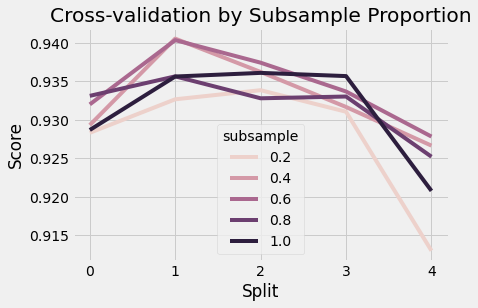

In [11]:
_ = sns.lineplot(x='split', y='value', hue='subsample', data=cv_df, palette=customPalette)
_.set(xlabel='Split', ylabel='Score', title='Cross-validation by Subsample Proportion')
plt.savefig('xgboost', bbox_inches='tight')
plt.show()